In [1]:
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders, Concepts
import pandas as pd
import numpy as np
import urllib.parse
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# !pip install pyalex # uncomment to install

In [4]:
# ANSI escape codes for colors
GREEN = '\033[92m'
RED = '\033[91m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
RESET = '\033[0m'
MAGENTA = '\033[35m'
CYAN = '\033[36m'

## Reading (and sampling) the data

`biomedical_data.csv` is a subset of the original dataset containing publications __from the last 5 years__ and from __biomedical institutions only__ - amcpub, lumc, vumc, umcu. It contains 1856 records.

In the code the first two contributors are considered (as potential supervisors) - `contributors_lst(df)` takes a specific numer of columns of a `df` - can be changed if needed.

In [185]:
df = pd.read_csv("biomedical_data.csv")
sampled_df = df.sample(n=5, random_state=40)
# sampled_df = df

In [186]:
def author_title_pairs_lst(df):
    tuples_list = []                                             # create pairs (author, title) for each row of the df
    for index, row in df.iterrows():
        tuple_values = (row['author_name'], row['title'])
        tuples_list.append(tuple_values)
    return tuples_list

def contributors_lst(df):
    contributors_list = []                                       # create lists of contributors for each row of the df
    for index, row in df.iloc[:, 7:9].iterrows():
        contributors = []
        for value in row:
            if type(value) != float:
                contributors.append(value)
        contributors_list.append(contributors)
    return contributors_list

In [187]:
author_title_pairs = author_title_pairs_lst(sampled_df)
contributors_list = contributors_lst(sampled_df)

## Find the author

#### Get pubs from our df

In [188]:
def get_name(row):                                                     # needs a row of the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)   # adding space between initials if there is no
    if len(matched_initials)>0 and len(matched_initials[0])>2:         # essential transformation if authors cannot be matched
        initials_list = list(initials)                                 # with found title
        for initial in initials_list:
            if initial == ".":
                initials_list.remove(initial)
        name = ""
        for initial in initials_list:
            name += initial + ". "
        name += surname
    else:
        name = initials + " " + surname
    return name

def get_name_without_spaces(row):                                      # name as it is in the pubs df
    author = author_title_pairs[row][0]
    if "," not in author:
        surname = author.split(" ")[0]
        initials = author.split(" ")[1].strip()
    else:
        surname = author.split(",")[0]
        initials = author.split(",")[1].strip()
    name = initials + " " + surname
    return name

In [189]:
def title_transform(row):
    title = author_title_pairs[row][1]
    replace_dict = {'&': '', ',': ''}
    for k,v in replace_dict.items():
        title = title.replace(k,v)
    title = urllib.parse.quote(title)
    return title

#### Confirm the author

Create global variables for finding/not finding the author messages

In [191]:
found_with_title = 0
found_with_title_name_var = 0
found_with_str = 0
found_with_str_var = 0
not_found = 0

In [192]:
def confirm_author(row):                                                 # match to existing work, if not found, search by name

    author_id = ''

    try:
        query = Works().search_filter(title=title_transform(row)).get()

        if query == []:
            return "Title not matched"    # based on name

        print(f'{len(query)} match(es) for the title found')
        for response in query:
            found = False
            if response["authorships"] == []:
                print("No record of author for this title")
            for author in response["authorships"]:
                if author["author"]["display_name"] == get_name(row):    # first try matching on "raw" name
                    print(MAGENTA + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                    global found_with_title
                    found_with_title += 1
                    author_id = author["author"]["id"]
                    found = True
                if found == False:                                       # raw name matches based on the exact same string
                    global found_with_title_name_var
                    q = Authors()[author["author"]["id"]]                # if not found check with ID
                    if (q["display_name"] == get_name(row) or get_name(row) in q["display_name_alternatives"]) or (q["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in q["display_name_alternatives"]):
                        print(YELLOW + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                        found_with_title_name_var += 1
                        author_id = author["author"]["id"]
                        found = True
                    if (q["display_name"].lower() == get_name(row).lower() or q["display_name"].lower() == get_name_without_spaces(row).lower()):
                        print(YELLOW + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                        found_with_title_name_var += 1
                        author_id = author["author"]["id"]
                        found = True
                    if q["display_name_alternatives"] != []:
                        for n in q["display_name_alternatives"]:
                            if (n.lower() == get_name(row).lower() or n.lower() == get_name_without_spaces(row).lower()):
                                print(YELLOW + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                                found_with_title_name_var += 1
                                author_id = author["author"]["id"]
                                found = True
                    if found == False:
                        print("Could not match {} to {}".format(get_name(row), q["display_name_alternatives"]))
                if found:
                    break
            if found:
                break


    except Exception as e:
        print("An unexpected error occurred:", e)


    if author_id != '':
        return author_id
    if author_id == None:
        return "Confirming author not successful"
    else:
        return "Confirming author not successful"

In [193]:
def title_DOI(row, confirmed_id):                                         # returns DOI of the title if the author is matched
                                                                          # based on that title
    DOIs = []

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        query = Works().search_filter(title=title_transform(row)).get()
        for response in query:
            DOIs.append(response["doi"])

    return DOIs

In [194]:
def get_author_id(row):                                                   # returns final author ID

    confirmed_id = confirm_author(row)

    if confirmed_id not in ["Confirming author not successful", "Title not matched"]:
        return confirmed_id

    query = Authors().search_filter(display_name=get_name(row)).get()

    if query == []:
        query = Authors().search_filter(display_name=get_name_without_spaces(row)).get()

    end_message = confirmed_id
    confirmed_id = ''

    print("{} match(es) for the author found".format(len(query)))
    for response in query:
        global found_with_str
        global found_with_str_var
        found = False
        if (response["display_name"] == get_name(row) or get_name(row) in response["display_name_alternatives"]) or (response["display_name"] == get_name_without_spaces(row) or get_name_without_spaces(row) in response["display_name_alternatives"]):
            print(BLUE + "PhD candidate found! - {}".format(get_name(row)) + RESET)
            found_with_str += 1
            confirmed_id = response["id"]
            found = True
        else:                                                               # many other cases ! - DOUBLE SURNAMES - NOT CLEAR WAY TO HANDLE (193 on rs 42)
            if get_name(row).lower() == response["display_name"].lower():
                print(CYAN + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                found_with_str_var += 1
                confirmed_id = response["id"]
                found = True
            normalized_name1 = ' '.join(sorted(get_name(row).split()))
            normalized_name2 = ' '.join(sorted(response["display_name"].split()))
            if normalized_name1 == normalized_name2:
                print(CYAN + "PhD candidate found! - {}".format(get_name(row)) + RESET)
                found_with_str_var += 1
                confirmed_id = response["id"]
                found = True
        if found:
            break

    if confirmed_id != '':
        return confirmed_id
    else:
        global not_found
        not_found += 1
        return "PhD candidate (probably) not in Open Alex database"                 # OR AUTHOR NOT MATCHED !

Output colors:

__Magenta__ - author found in OpenAlex authors based on matched title

__Yellow__ - author found in OpenAlex authors based on matched title, for alternative version of author's name

__Blue__ - author found in OpenAlex authors

__Cyan__ - alternative version of author's name (likely the author) found in OpenAlex authors

## Get DOIs for the author

Not every work in Open Alex has a DOI, thus the returned list of DOIs may be shorter than the number of papers where the author was the first author. The DOI of the work that is already in pubs dataframe is also not included in the list - __only new DOIs are returned__.

In [195]:
def author_DOIs(row):

    author_id = get_author_id(row)
    if author_id == "PhD candidate (probably) not in Open Alex database":
        print(RED + "Cannot be resolved" + RESET)
        return author_id
    initial_doi = title_DOI(row, author_id)

    result = Works().filter(authorships={"author": {"id": author_id}}).get()
    print("Number of papers where the author was credited: {}".format(len(result)))

    DOIs = []

    i = 0
    for w in result:
        if w["authorships"][0]["author"]["id"] == author_id:
            i += 1
            if w["doi"] != None and w["doi"] not in initial_doi:
                DOIs.append(w["doi"])

    print("Number of papers where the PhD candidate was the first author: {}".format(i))

    if DOIs == []:
        return "No DOIs for the PhD candidate found"
    else:
        return DOIs

In [196]:
# author_DOIs(1)

## Get DOIs for the contributors

#### Transform contributors' names

In [197]:
def contributors_transformed(row):                                             # with space

    contributors = contributors_list[row]
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        matched_initials = re.findall(r'\b[A-Z](?:\.[A-Z])\b', initials)
        if len(matched_initials)>0 and len(matched_initials[0])>2:
            initials_list = list(initials)
            for initial in initials_list:
                if initial == ".":
                    initials_list.remove(initial)
            name = ""
            for initial in initials_list:
                name += initial + ". "
            name += surname
        else:
            name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

def contributors_original(row):                                                # as originally in the data
                                                                               # will be used when the transformed names won't
    contributors = contributors_list[row]                                      # match
    transformed_names = []

    for contribtor in contributors:
        surname = contribtor.split(",")[0]
        initials = contribtor.split(",")[1].strip()
        name = initials + " " + surname
        transformed_names.append(name)

    return transformed_names

#### Find contributors (get IDs)

Create global variables for finding/not finding the author messages

In [198]:
contributor_found_with_str = 0
contributor_found_with_str_var = 0
contributor_manual_check = 0
contributor_not_found = 0

In [199]:
def get_contributors_ids(row):                                                 # returns a list of tuples of contributors and
                                                                               # their corresponding confirmed ids
    contributors = contributors_transformed(row)
    original_contributors = contributors_original(row)
    contributors_ids = []

    for contributor, og_contributor in zip(contributors, original_contributors):
        global contributor_found_with_str
        global contributor_found_with_str_var
        global contributor_manual_check
        global contributor_not_found
        manual = 0
        cont_not_found = 0
        print("Matching {}...".format(contributor))
        found = False
        response_list = []
        query = Authors().search_filter(display_name=contributor).get()        # 2 queries everytime could be too comp expens.
        if query == []:                                                        # check the difference?
            query = Authors().search_filter(display_name=og_contributor).get()
        if query == []:
            print(RED + "        Cannot be resolved: " + RESET + "Could not find the author {}".format(contributor))
            cont_not_found = 1
        else:
            print("        Found {} matches for {}".format(len(query), contributor))
            for i, response in enumerate(query):
                print("          {}:".format(i+1))
                if (response["display_name"] == contributor or contributor in response["display_name_alternatives"]) or (response["display_name"] == og_contributor or og_contributor in response["display_name_alternatives"]):
                    print(BLUE + "            Contributor found! - {}".format(contributor) + RESET)
                    manual = 0
                    cont_not_found = 0
                    contributor_found_with_str += 1
                    contributors_ids.append((contributor, response["id"]))
                    found = True
                else:
                    if contributor.lower() == response["display_name"].lower():
                        print(CYAN + "            Contributor found! - {}".format(contributor) + RESET)
                        manual = 0
                        cont_not_found = 0
                        contributor_found_with_str_var += 1
                        contributors_ids.append((contributor, response["id"]))
                        found = True
                if found == False:
                    if response["affiliations"] == []:
                        print(RED + "            No affiliations with institutions - unable to match" + RESET)
                        cont_not_found = 1
                    else:
                        for institution in response["affiliations"]:
                            if institution["institution"]["country_code"] == "NL":
                                print("            {} associated with {}, NL".format(response["display_name"], institution["institution"]["display_name"]))
                                print("            {} maybe associated with {}".format(contributor, response["display_name"]))
                                print(MAGENTA + "            Requires manual check to confirm" + RESET)
                                manual = 1
                                if ("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]) not in contributors_ids:
                                    response_list.append(("MANUAL CHECK: if {} (target) is {} (found)".format(contributor, response["display_name"]), response["id"]))
                            else:
                                print(RED + "            No NL institution - unlikely to be the match" + RESET)
                                cont_not_found = 1
                if found:
                    break
                if i == len(query)-1:
                    contributors_ids.extend(response_list)
            if manual == 1:
                contributor_manual_check += 1
            if cont_not_found == 1:
                contributor_not_found += 1

    if contributors_ids == []:
        return "None of the contributors is in Open Alex database"
    else:
        return contributors_ids

### Get DOIs

In [200]:
def contributors_DOIs(row):

    ids_list = get_contributors_ids(row)
    confirmed = []
    manual_check = []

    for pair in ids_list:
        if "MANUAL CHECK" in pair[0]:
            if pair not in manual_check:
                manual_check.append(pair)
        else:
            confirmed.append(pair)

    if ids_list == "None of the contributors is in Open Alex database":
        return ids_list


    DOIs_dict = {}

    for author in confirmed:
        author_id = author[1]
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
        print()
        print("Searching works for {}...".format(author[0]))
        print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

        print("        Number of papers where the contributor was the first author: {}".format(i))

        if author[0] not in DOIs_dict:
            DOIs_dict[author[0]] = DOIs

    for author in manual_check:
        author_id = author[1]
        extract_name = re.search(r'if\s+(.*?)\s+is', author[0])
        name = extract_name.group(1)
        result = Works().filter(authorships={"author": {"id": author_id}}).get()
        print()
        print("Searching works for {}... - NOT CONFIRMED".format(name))
        print("        Number of papers where the contributor was credited as an author: {}".format(len(result)))

        DOIs = []

        i = 0
        for w in result:
            if w["authorships"][0]["author"]["id"] == author_id:
                i += 1
                if w["doi"] != None:
                    DOIs.append(w["doi"])

        print("        Number of papers where the contributor was the first author: {}".format(i))

        name = name + " - NOT CONFIRMED"
        if name not in DOIs_dict:
            DOIs_dict[name] = DOIs


    if DOIs_dict == {}:
        return "No DOIs for the associated contributors found"

    got_dois = False
    for value in DOIs_dict.values():
        if value != []:
            got_dois = True
    if got_dois:
        return DOIs_dict
    else:
        return "No DOIs for the associated contributors found"

In [201]:
# contributors_DOIs(3)

## Run on a subset

Store the output in `dois_df`

In [202]:
dois_data = []  # empty list to store data for each row of the df

for i in tqdm(range(len(sampled_df))):  
    contributors = contributors_DOIs(i)  # get the DOIs of contributors for every row (i)

    # check if there are no DOIs for contributors or if none of the contributors are in the Open Alex database
    if contributors == "None of the contributors is in Open Alex database" or contributors == "No DOIs for the associated contributors found":
        message_contributors = contributors  # store the message for why there are no DOIs for contributors
        contributors = np.nan  # set contributors to NaN since no valid DOIs were found
        contr_count = 0  # set the count of contributors with DOIs to 0
        contr_dois_count = 0  # set the cumulative count of DOIs for contributors to 0
    else:
        # calculate the number of contributors with DOIs and the cumulative count of DOIs
        contr_count = sum(1 for lst in contributors.values() if lst)
        contr_dois_count = sum(len(lst) for lst in contributors.values())
        message_contributors = np.nan  # no error message needed since DOIs were found

    author_dois = author_DOIs(i)  # get the DOIs of the author (PhD candidate) for the current row (i)

    # check if there are no DOIs for the author or if the author is not in the Open Alex database
    if author_dois == "PhD candidate (probably) not in Open Alex database" or author_dois == "No DOIs for the PhD candidate found":
        message_author = author_dois  # store the message for why there are no DOIs for the author
        author_dois = np.nan  # set author DOIs to NaN since no valid DOIs were found
        count = 0  # set the count of DOIs for the author to 0
    else:
        count = len(author_dois)  # set the count of DOIs for the author
        message_author = np.nan  # no error message needed since DOIs were found

    # create a dictionary with all the relevant information for the current row
    data = {
        'PhD candidate': get_name_without_spaces(i),  
        'PhD candidate DOIs found in OpenAlex': author_dois,  
        'DOIs count': count,  
        'Contributors-DOIs Dictionary': contributors, 
        'Number of contributors with DOIs found in OpenAlex': contr_count, 
        'Cumulative found Contributor DOIs count': contr_dois_count,
        'Why no DOIs for PhD candidate': message_author,  
        'Why no DOIs for contributors': message_contributors 
    }
    dois_data.append(data)  # append the dictionary to the list of data

dois_df = pd.DataFrame(dois_data)  # convert the list of dictionaries into a DataFrame

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Matching J. W. Groothoff...
        Found 1 matches for J. W. Groothoff
          1:
            Contributor found! - J. W. Groothoff
Matching J. J. P. Kastelein...
        Found 3 matches for J. J. P. Kastelein
          1:
            Contributor found! - J. J. P. Kastelein

Searching works for J. W. Groothoff...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 1

Searching works for J. J. P. Kastelein...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 2
1 match(es) for the title found
Could not match Ilse K. Luirink to ['L. Galimova', 'Л. Ф Галимова', 'Liliia F. Galimova', 'Л. Ф. Галимова', 'Liliia Galimova', 'Liliya F. Galimova', 'L.F. Galimova Galimova', 'L.F Galimova', 'L. F. Galimova']
Could not match Ilse K. Luirink to ['Dinara I. Sadykova', 'Д. И. Садыкова', 'Anastasiya V. Ishbuldina',

 20%|████████████████▊                                                                   | 1/5 [00:13<00:52, 13.01s/it]

Number of papers where the author was credited: 24
Number of papers where the PhD candidate was the first author: 11
Matching M. D. de Jong...
        Found 10 matches for M. D. de Jong
          1:
            E. M. L. D. de Jong associated with University of Amsterdam, NL
            M. D. de Jong maybe associated with E. M. L. D. de Jong
            Requires manual check to confirm
            No NL institution - unlikely to be the match
          2:
            No affiliations with institutions - unable to match
          3:
            No NL institution - unlikely to be the match
            D. M. de Jong associated with University of Amsterdam, NL
            M. D. de Jong maybe associated with D. M. de Jong
            Requires manual check to confirm
          4:
            D. G. M. M. De Jong associated with University of Amsterdam, NL
            M. D. de Jong maybe associated with D. G. M. M. De Jong
            Requires manual check to confirm
          5:
            YDE 

 40%|█████████████████████████████████▌                                                  | 2/5 [00:23<00:33, 11.31s/it]

0 match(es) for the author found
Cannot be resolved
Matching A. Popma...
        Found 9 matches for A. Popma
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - A. Popma
Matching R. Vermeiren...
        Found 10 matches for R. Vermeiren
          1:
            No affiliations with institutions - unable to match
          2:
            Contributor found! - R. Vermeiren

Searching works for A. Popma...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0

Searching works for R. Vermeiren...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:26<00:15,  7.83s/it]

0 match(es) for the author found
Cannot be resolved
Matching N. P. Juffermans...
        Found 1 matches for N. P. Juffermans
          1:
            Contributor found! - N. P. Juffermans
Matching J. C. Goslings...
        Found 4 matches for J. C. Goslings
          1:
            No affiliations with institutions - unable to match
          2:
            No affiliations with institutions - unable to match
          3:
            Contributor found! - J. C. Goslings

Searching works for N. P. Juffermans...
        Number of papers where the contributor was credited as an author: 25
        Number of papers where the contributor was the first author: 1

Searching works for J. C. Goslings...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 1
1 match(es) for the author found
PhD candidate found! - Mathijs R. Wirtz


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:33<00:07,  7.26s/it]

Number of papers where the author was credited: 17
Number of papers where the PhD candidate was the first author: 7
Matching H. Heijerman...
        Found 5 matches for H. Heijerman
          1:
            H Heijerman associated with University Medical Center Utrecht, NL
            H. Heijerman maybe associated with H Heijerman
            Requires manual check to confirm
            H Heijerman associated with Rijnstate Hospital, NL
            H. Heijerman maybe associated with H Heijerman
            Requires manual check to confirm
          2:
            Contributor found! - H. Heijerman
Matching C.v.d. Ent...
        Cannot be resolved: Could not find the author C.v.d. Ent

Searching works for H. Heijerman...
        Number of papers where the contributor was credited as an author: 1
        Number of papers where the contributor was the first author: 0
1 match(es) for the title found
PhD candidate found! - Marcella Burghard


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.70s/it]

Number of papers where the author was credited: 25
Number of papers where the PhD candidate was the first author: 10


In [204]:
dois_df = pd.DataFrame(dois_data)
dois_df

,PhD candidate,PhD candidate DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count,Why no DOIs for PhD candidate,Why no DOIs for contributors
0,Ilse K. Luirink,"[https://doi.org/10.1056/nejmoa1816454, https:...",10,{'J. W. Groothoff': ['https://doi.org/10.1136/...,2,3,NaN,NaN
1,Hana A. Pawestri,NaN,0,{'M. D. de Jong (target) - NOT CONFIRMED': ['h...,1,6,PhD candidate (probably) not in Open Alex data...,NaN
2,Katharina Margitta Visser,NaN,0,NaN,0,0,PhD candidate (probably) not in Open Alex data...,No DOIs for the associated contributors found
3,Mathijs R. Wirtz,"[https://doi.org/10.1111/trf.15917, https://do...",7,NaN,0,0,NaN,No DOIs for the associated contributors found
4,Marcella Burghard,"[https://doi.org/10.1123/jpah.2016-0299, https...",9,NaN,0,0,NaN,No DOIs for the associated contributors found


In [231]:
dois_df.to_csv('results.csv', index=False) 

Statistics for how and if PhD candidates / contributors were found:

In [228]:
phd_cand_verification = {
    "Number of PhD candidates found with matched title": found_with_title,
    "Number of PhD candidates found with matched title, but name variation": found_with_title_name_var,
    "Number of PhD candidates found with name string": found_with_str,
    "Number of PhD candidates found with name string variation": found_with_str_var,
    "Number of not found PhD candidates": not_found
}

contributor_verification = {
    "Number of contributors found with name string": contributor_found_with_str,
    "Number of contributors found with name string variation": contributor_found_with_str_var,
    "Number of contributors for manual check": contributor_manual_check,
    "Number of not found contributors": contributor_not_found
}

df_pnd_cand_ver = pd.DataFrame(list(phd_cand_verification.items()), columns=["Found how?", "Value"])
df_contributor_ver = pd.DataFrame(list(contributor_verification.items()), columns=["Found how?", "Value"])

In [229]:
df_pnd_cand_ver

,Found how?,Value
0,Number of PhD candidates found with matched title,1
1,Number of PhD candidates found with matched ti...,0
2,Number of PhD candidates found with name string,2
3,Number of PhD candidates found with name strin...,0
4,Number of not found PhD candidates,2


In [230]:
df_contributor_ver

,Found how?,Value
0,Number of contributors found with name string,7
1,Number of contributors found with name string ...,0
2,Number of contributors for manual check,1
3,Number of not found contributors,2


## Visualisations & Statistics

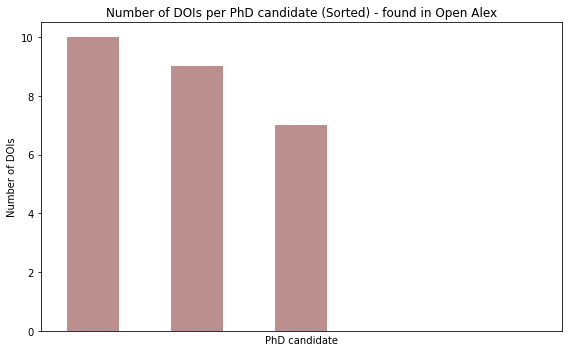

In [206]:
author_doi_counts = dois_df.groupby('PhD candidate')['DOIs count'].sum()

author_doi_counts = author_doi_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_doi_counts.plot(kind='bar', color='rosybrown')
plt.title('Number of DOIs per PhD candidate (Sorted) - found in Open Alex')
plt.ylabel('Number of DOIs')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

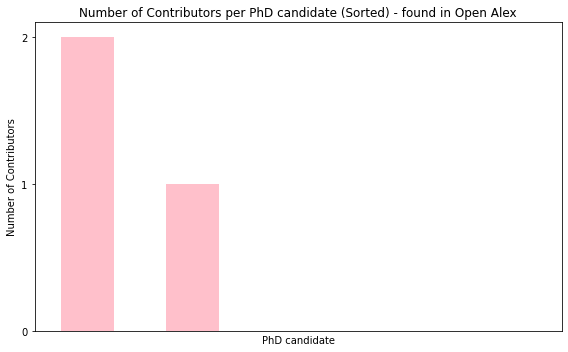

In [207]:
author_contributors_count = dois_df.groupby('PhD candidate')['Number of contributors with DOIs found in OpenAlex'].sum()

author_contributors_count = author_contributors_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_contributors_count.plot(kind='bar', color='pink')
plt.title('Number of Contributors per PhD candidate (Sorted) - found in Open Alex')
plt.ylabel('Number of Contributors')
plt.locator_params(axis='y', integer=True)
plt.xticks([])
plt.tight_layout()
plt.show()

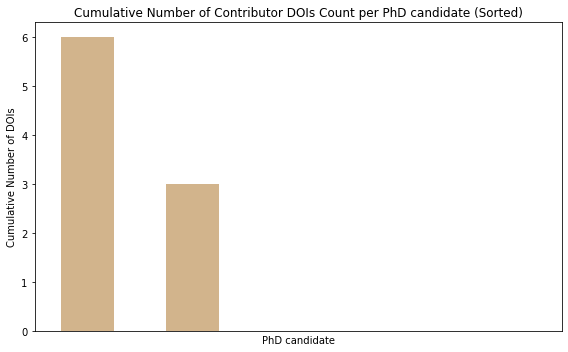

In [208]:
author_cumulative_dois_count = dois_df.groupby('PhD candidate')['Cumulative found Contributor DOIs count'].sum()

author_cumulative_dois_count = author_cumulative_dois_count.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
author_cumulative_dois_count.plot(kind='bar', color='tan')
plt.title('Cumulative Number of Contributor DOIs Count per PhD candidate (Sorted)')
plt.ylabel('Cumulative Number of DOIs')

plt.locator_params(axis='y', integer=True)

plt.xticks([])
plt.tight_layout()
plt.show()

In [209]:
mean_dois_per_author = dois_df['DOIs count'].mean()
median_dois_per_author = dois_df['DOIs count'].median()

mean_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = dois_df['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = dois_df['Cumulative found Contributor DOIs count'].median()

nan_author_dois_count = dois_df['PhD candidate DOIs found in OpenAlex'].isnull().sum()
nan_contributors_dois_count = dois_df['Contributors-DOIs Dictionary'].isnull().sum()

summary_data = {
    'Statistics': ['Mean DOIs per PhD candidate', 'Median DOIs per PhD candidate',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count',
                   'NaN Values for PhD candidate DOIs', 'NaN Values for Contributors DOIs'],
    'Values': [mean_dois_per_author, median_dois_per_author,                           # round if needed
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count,
               nan_author_dois_count, nan_contributors_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per PhD candidate,5.2
1,Median DOIs per PhD candidate,7.0
2,Mean Found Contributors,0.6
3,Median Found Contributors,0.0
4,Mean Cumulative DOIs Count,1.8
5,Median Cumulative DOIs Count,0.0
6,NaN Values for PhD candidate DOIs,2.0
7,NaN Values for Contributors DOIs,3.0


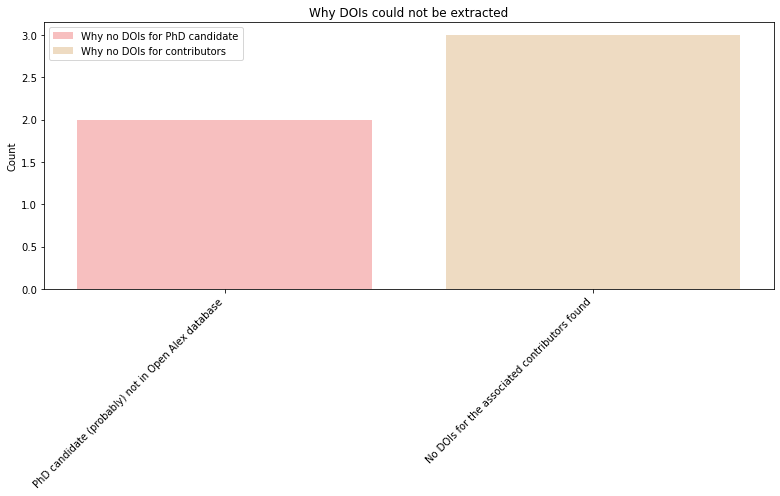

In [210]:
dois_df.fillna('Unknown', inplace=True)

unique_messages_column1 = dois_df['Why no DOIs for PhD candidate'].value_counts()
unique_messages_column2 = dois_df['Why no DOIs for contributors'].value_counts()

unique_messages_column1 = unique_messages_column1.drop('Unknown', errors='ignore')
unique_messages_column2 = unique_messages_column2.drop('Unknown', errors='ignore')

plt.figure(figsize=(11, 7))

plt.bar(unique_messages_column1.index, unique_messages_column1.values, alpha=0.5, label='Why no DOIs for PhD candidate', color='lightcoral')
plt.bar(unique_messages_column2.index, unique_messages_column2.values, alpha=0.5, label='Why no DOIs for contributors', color='burlywood')

plt.ylabel('Count')
plt.title('Why DOIs could not be extracted')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

### Filter for the task at hand

In [211]:
df_clean = dois_df.iloc[:, :6].dropna()
# df_clean.reset_index(drop=True, inplace=True)
df_clean

,PhD candidate,PhD candidate DOIs found in OpenAlex,DOIs count,Contributors-DOIs Dictionary,Number of contributors with DOIs found in OpenAlex,Cumulative found Contributor DOIs count
0,Ilse K. Luirink,"[https://doi.org/10.1056/nejmoa1816454, https:...",10,{'J. W. Groothoff': ['https://doi.org/10.1136/...,2,3
1,Hana A. Pawestri,Unknown,0,{'M. D. de Jong (target) - NOT CONFIRMED': ['h...,1,6
2,Katharina Margitta Visser,Unknown,0,Unknown,0,0
3,Mathijs R. Wirtz,"[https://doi.org/10.1111/trf.15917, https://do...",7,Unknown,0,0
4,Marcella Burghard,"[https://doi.org/10.1123/jpah.2016-0299, https...",9,Unknown,0,0


In [212]:
mean_dois_per_author = df_clean['DOIs count'].mean()
median_dois_per_author = df_clean['DOIs count'].median()

mean_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].mean()
median_found_contributors = df_clean['Number of contributors with DOIs found in OpenAlex'].median()

mean_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].mean()
median_cumulative_dois_count = df_clean['Cumulative found Contributor DOIs count'].median()

summary_data = {
    'Statistics': ['Mean DOIs per PhD candidate', 'Median DOIs per PhD candidate',
                   'Mean Found Contributors', 'Median Found Contributors',
                   'Mean Cumulative DOIs Count', 'Median Cumulative DOIs Count'],
    'Values': [mean_dois_per_author, median_dois_per_author,
               mean_found_contributors, median_found_contributors,
               mean_cumulative_dois_count, median_cumulative_dois_count]
}

summary_df = pd.DataFrame(summary_data)

summary_df

,Statistics,Values
0,Mean DOIs per PhD candidate,5.2
1,Median DOIs per PhD candidate,7.0
2,Mean Found Contributors,0.6
3,Median Found Contributors,0.0
4,Mean Cumulative DOIs Count,1.8
5,Median Cumulative DOIs Count,0.0


In [173]:
# df_clean.to_csv('complete_extraction.csv', index=False)